# Machine Learning WAF

In this project, I will build a Web Application Firewall that examines an incoming HTTP request and performs binary classification; labeling that request as either malicious or not. Dataset has been obtained from previous Kaggle competion:

[Malicious Intent Detention Challenge](https://www.kaggle.com/c/wallarm-ml-hackathon)

The first step in working with any dataset is loading the data in and noting what information is included in the dataset. This is an important step in eventually working with this data, and knowing what kinds of features you have to work with as you transform and group the data!

So, this notebook is all about exploring the data and noting patterns about the features you are given and the distribution of data. 



## Read in the Data

The cell below will read the necessary data within the `datasets/`.


In [1]:
# import libraries
import pandas as pd
!/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install -U numpy
import numpy as np
import os
import msgpack


# Read Training MSGPACK file un unpack data
with open('datasets/train.msgpack','rb') as data_file:
    byte_data = data_file.read()

data = msgpack.unpackb(byte_data)

# Create Pandas Dataframe from CSV file and use 'ID' column as Index
labels_df = pd.read_csv('datasets/train_info.csv')
labels_df.dropna(inplace=True)
labels_df.reset_index(drop=True,inplace=True)
labels_df.columns = ['ID', 'Attack']
test_labels_df = labels_df.set_index('ID')
print(len(labels_df))



     |████████████████████████████████| 20.1 MB 3.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
65854


## Label Merge

In [2]:

payload_dictionary = {}
for i in range(len(data)):
    payload_dictionary.update({data[i][0]:data[i][1]})

# Create Pandas Dataframe from dictionary using ID Column as index
attack_df = pd.DataFrame.from_dict(payload_dictionary, orient = 'index', columns=['Payload'])

# Merge both Pandas Dataframes using the index as concatenation point
mergedDf = attack_df.merge(test_labels_df, left_index=True, right_index=True)
mergedDf.reset_index(drop=True, inplace=True)

# Change 'Attack' column to 0 or 1
mergedDf['Attack'] = np.where(mergedDf['Attack'] == False, 0, 1)
print(mergedDf.head())

                                             Payload  Attack
0  ' and/**/38>( select\t(622)/**/from/*362 emhgp...       1
1  shqpkt" union /*!426 all\t*/(select kwicwt(\t(...       1
2  nhnqag" uniondistinct--154 298 plhlre exaloq u...       1
3                                     D8j+oNbylTIGw=       0
4  ened \">\n  <head>\n    <script data-react-hel...       0


## Parse and Clean Data

In [3]:
import urllib.parse

#for i in range(mergedDf.shape[0]):
for i in range(mergedDf.shape[0]):
    rawPath = ''
    rawQuery = ''
    if '?' in mergedDf.iloc[i].values[0]:
        path_query = mergedDf.iloc[i].values[0].split('?')
        #print(i,'?')
        #print(urllib.parse.parse_qsl(path_query[1]))
        queryStr = urllib.parse.parse_qsl(path_query[1])
        if queryStr:
            query = []
            for item in queryStr:
                query.append(' '.join(item))
            rawQuery = ' '.join(query)
        else:
            rawQuery = urllib.parse.unquote(path_query[1])
        path = []
        for seg in path_query[0].split('/'):
             path.append(urllib.parse.unquote(seg.strip()))
        rawPath = ' '.join(path)
    else:
        #print(i,'-')
        queryStr = urllib.parse.parse_qsl(mergedDf.iloc[i].values[0])
        if queryStr:
            query = []
            for item in queryStr:
                query.append(' '.join(item))
            rawQuery = ' '.join(query)
        else:
            rawQuery = urllib.parse.unquote(mergedDf.iloc[i].values[0])
    #print(rawPath,rawQuery)
    #print(mergedDf.iloc[i].values[0],'\n')
    mergedDf['Payload'][i] = rawPath+rawQuery

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Data Visualizations

In [4]:
import sys
print(sys.executable)

/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python


In [5]:
# Library import

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install wordcloud
from wordcloud import WordCloud



     |████████████████████████████████| 364 kB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## WordCloud Malicious Traffic

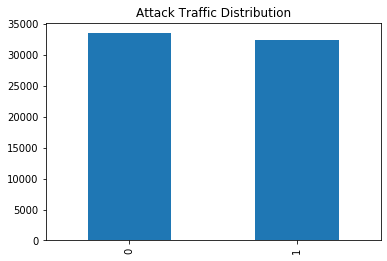

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot Attack Distribution
pd.value_counts(mergedDf["Attack"]).plot.bar()
plt.title("Attack Traffic Distribution")
plt.figure()
plt.show()

In [7]:
stop_words = frozenset(['keep', 'language', 'referer', 'user',"User","Host","Accept","example",\
                        "Language","Connection","https","http","Referer","en","us","US","Keep",\
                        "host","like","www","user","language","gzip","accept","Cookie","cookie"])


## WordCloud - Malicious HTTP Requests

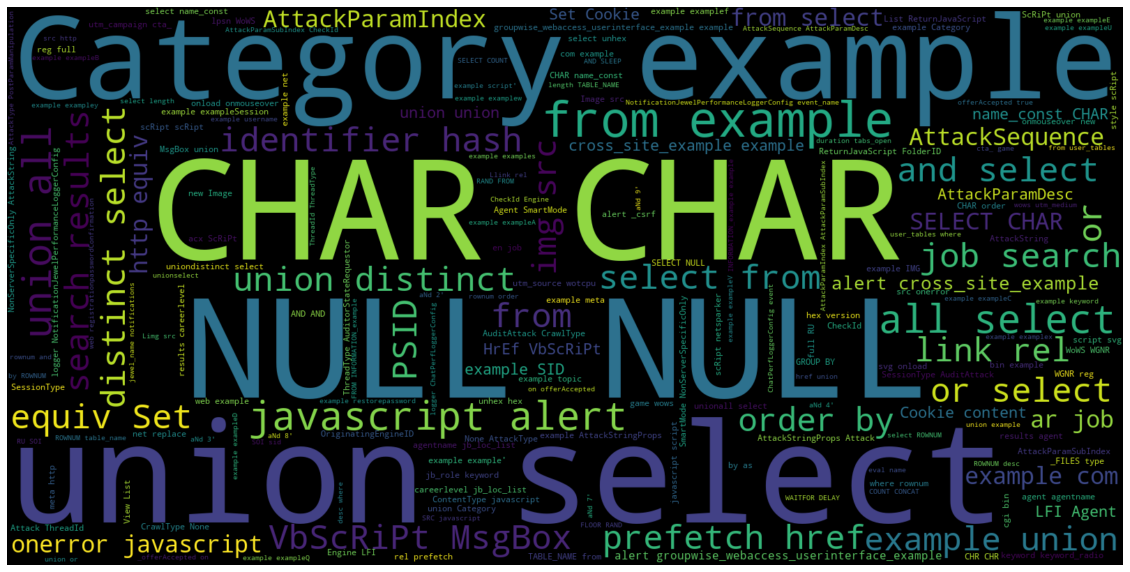

In [8]:
# WordCloud for Attacks

neg_req = mergedDf[mergedDf.Attack == 1]
neg_string = []
for t in neg_req.Payload:
    #print (t)
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,stopwords=stop_words,relative_scaling=0.01).generate(neg_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## WordCloud - Normal HTTP Requests

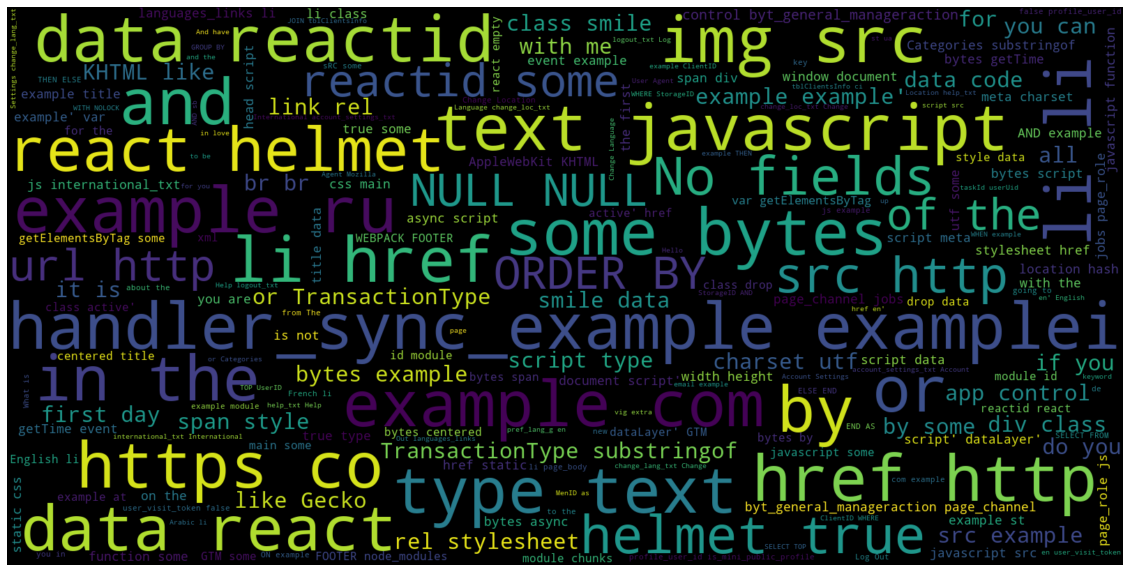

In [9]:
# WordCloud for Normal HTTP

pos_req = mergedDf[mergedDf.Attack == 0]
pos_string = []
for t in pos_req.Payload:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,stopwords=stop_words,relative_scaling=0.01).generate(pos_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Randomize and Split Data

In [10]:

# RandomizeData

randomTest = mergedDf.sample(frac=1).reset_index(drop=True)


# Data Split
x = randomTest.Payload
y = randomTest.Attack
from sklearn.model_selection import train_test_split
SEED = 2000

train_data, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, \
                                                                                  random_state=SEED)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, \
                                                              test_size=.5, random_state=SEED)

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(train_data),(len(train_data[y_train == 1]) / (len(train_data)*1.))*100,(len(train_data[y_train == 0]) / (len(train_data)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))



Train set has total 52683 entries with 49.29% negative, 50.71% positive
Validation set has total 6585 entries with 51.24% negative, 48.76% positive
Test set has total 6586 entries with 51.81% negative, 48.19% positive


In [11]:
x_validation.iloc[4]

'bmuddm" union/*!*/'

## Bag of Words and XGBoost

In [12]:

import re
from bs4 import BeautifulSoup

def review_to_words(review):    
    text = re.sub(r"[^a-zA-Z0-9]", " ", review.lower()) # Convert to lower case
    words = text.split() # Split string into words
    return words

In [13]:
print(train_data.shape)
print(train_data.iloc[1])
#print(train_data[2])
print(review_to_words(train_data.iloc[1]))
for request in train_data[:2]:
    print(request)

(52683,)
!.linkCrel prefetchhref=29424.
['linkcrel', 'prefetch', 'href', '29424']
!)tV�l:�\HU�J
!.linkCrel prefetchhref=29424.


In [14]:
import pickle

cache_dir = os.path.join("../cache", "aiwaf")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, data_validation, labels_train, labels_test, labels_validation,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        words_validation = [review_to_words(review) for review in data_validation]
        #print(words_train)
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test, words_validation=words_validation,
                              labels_train=labels_train, labels_test=labels_test, labels_validation=labels_validation)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, words_validation, labels_train, labels_test, labels_validation = (cache_data['words_train'],
                cache_data['words_test'], cache_data['words_validation'], cache_data['labels_train'], cache_data['labels_test'], cache_data['labels_validation'])
    
    return words_train, words_test, words_validation, labels_train, labels_test, labels_validation

In [15]:
# Preprocess data
train_X, test_X, validation_X, train_y, test_y, validation_y = preprocess_data(train_data, x_test, x_validation, y_train, y_test, y_validation)

Wrote preprocessed data to cache file: preprocessed_data.pkl


In [16]:
train_data = x_test = x_validation = y_train = y_test = y_validation = None

In [17]:
' '.join(train_X[4])

'474 and ipbrek select334from etmxmf'

In [18]:
def batch_join(train_X):
    new_train_X = []
    total_count = len(train_X)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = train_X[i*50:(i+1)*50]
        for line in batch:
            new_train_X.append(' '.join(line))
    return new_train_X

In [19]:
new_train_X = batch_join(train_X)
new_test_X = batch_join(test_X)
new_validation_X = batch_join(validation_X)

In [20]:
new_train_X[:5]

['d deaid k like c k i gu 9 s ck j tv l hu j',
 'linkcrel prefetch href 29424',
 'select from wp revslider slides where id 466 order by id limit 5',
 '1b2e5e77 642d 5d4d a931 396bd7441771 and 5 5',
 '474 and ipbrek select334from etmxmf']

#### Extract Bag of Words

In [21]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, words_validation, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_validation = vectorizer.transform(words_validation).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test, features_validation=features_validation,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, features_validation, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['features_validation'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, features_validation, vocabulary

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# Extract Bag of Words features for both training and test datasets
train_X, test_X, validation_X, vocabulary = extract_BoW_features(new_train_X, new_test_X, new_validation_X)

Wrote features to cache file: bow_features.pkl


In [23]:
len(validation_X[0])

5000

In [24]:
train_X[0][:5]

array([0, 0, 0, 0, 0])

## Step 3: Upload data to S3

Now that we have created the feature representation of our training (and testing) data, it is time to start setting up and using the XGBoost classifier provided by SageMaker.

### Writing the datasets

The XGBoost classifier that we will be using requires the dataset to be written to a file and stored using Amazon S3. To do this, we will start by splitting the training dataset into two parts, the data we will train the model with and a validation set. Then, we will write those datasets to a file locally and then upload the files to S3. In addition, we will write the test set to a file and upload that file to S3. This is so that we can use SageMakers Batch Transform functionality to test our model once we've fit it.

In [28]:

validation = pd.concat([pd.DataFrame(validation_y), pd.DataFrame(validation_X)], axis=1)
train = pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1)


''' OLD
val_X = pd.DataFrame(validation_X)
train_X = pd.DataFrame(train_X)
test_X = pd.DataFrame(test_X)

val_y = pd.DataFrame(validation_y)
train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)
'''

' OLD\nval_X = pd.DataFrame(validation_X)\ntrain_X = pd.DataFrame(train_X)\ntest_X = pd.DataFrame(test_X)\n\nval_y = pd.DataFrame(validation_y)\ntrain_y = pd.DataFrame(train_y)\ntest_y = pd.DataFrame(test_y)\n'

In [37]:
print(train.isnull().sum().sum())


MemoryError: Unable to allocate 2.36 GiB for an array with shape (5001, 63216) and data type float64

The documentation for the XGBoost algorithm in SageMaker requires that the training and validation datasets should contain no headers or index and that the label should occur first for each sample.

For more information about this and other algorithms, the SageMaker developer documentation can be found on __[Amazon's website.](https://docs.aws.amazon.com/sagemaker/latest/dg/)__

In [65]:
# First we make sure that the local directory in which we'd like to store the training and validation csv files exists.
data_dir = '../data/aiwaf'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [66]:
#pd.concat([test_y, test_X], axis=1).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)


pd.concat([val_y, val_X], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([train_y, train_X], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [67]:
# To save a bit of memory we can set text_X, train_X, val_X, train_y and val_y to None.

test_X = train_X = val_X = train_y = val_y = None

### Uploading Training / Validation files to S3

Amazon's S3 service allows us to store files that can be accessed by both the built-in training models such as the XGBoost model we will be using as well as custom models such as the one we will see a little later.

For this and most other tasks we will be doing using SageMaker, there are two methods we could use. The first is to use the low level functionality of SageMaker which requires knowing each of the objects involved in the SageMaker environment. The second is to use the high level functionality in which certain choices have been made on the user's behalf. The low level approach benefits from allowing the user a great deal of flexibility while the high level approach makes development much quicker. For our purposes we will opt to use the high level approach although using the low-level approach is certainly an option.

Recall the method `upload_data()` which is a member of the object representing our current SageMaker session. What this method does is upload the data to the default bucket (which is created if it does not exist) into the path described by the key_prefix variable. To see this for yourself, once you have uploaded the data files, go to the S3 console and look to see where the files have been uploaded.

For additional resources, see the __[SageMaker API documentation](http://sagemaker.readthedocs.io/en/latest/)__ and in addition the __[SageMaker Developer Guide.](https://docs.aws.amazon.com/sagemaker/latest/dg/)__

In [68]:
import sagemaker

session = sagemaker.Session() # Store the current SageMaker session

# S3 prefix (which folder will we use)
prefix = 'aiwaf'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


## SageMaker Role Setup

In [69]:
from sagemaker import get_execution_role

# Our current execution role is required when creating the model as the training
# and inference code will need to access the model artifacts.
role = get_execution_role()


## Step 4: Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed. In this example that takes between 7 and 11 minutes. Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers. Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup. More details on algorithm containers can be found in AWS documentation.


In [70]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [71]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv;label_size=0')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='text/csv;label_size=0')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [72]:
# Set default epochs
epochs = 15

# instantiate the LinearLearner estimator object
linear = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                 role,                                    # What is our current IAM Role
                                 train_instance_count=1,                  # How many compute instances
                                 train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                 output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                 sagemaker_session=session)

# And then set the algorithm specific parameters.
linear.set_hyperparameters(predictor_type='binary_classifier',
                          binary_classifier_model_selection_criteria='accuracy',
                          epochs=epochs)

### Fit the Linear model

Now that our model has been set up we simply need to attach the training and validation datasets and then ask SageMaker to set up the computation.

In [73]:
linear.fit({'train': s3_input_train})

2020-06-17 03:49:10 Starting - Starting the training job...
2020-06-17 03:49:12 Starting - Launching requested ML instances......
2020-06-17 03:50:13 Starting - Preparing the instances for training......
2020-06-17 03:51:14 Downloading - Downloading input data...
2020-06-17 03:52:06 Training - Downloading the training image...
2020-06-17 03:52:39 Uploading - Uploading generated training model
2020-06-17 03:52:39 Failed - Training job failed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/17/2020 03:52:29 INFO 139860235478848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u

UnexpectedStatusException: Error for Training job linear-learner-2020-06-17-03-49-09-913: Failed. Reason: ClientError: Found at least 193 entries in file /opt/ml/input/data/train/train.csv with missing values:
Row 3, column 1
Row 18, column 1
Row 27, column 1
Row 33, column 1
Row 40, column 1
Row 50, column 1
Row 55, column 1
Row 57, column 1
Row 58, column 1
Row 60, column 1
Row 62, column 1
Row 72, column 1
Row 77, column 1
Row 88, column 1
Row 89, column 1
Row 90, column 1
Row 99, column 1
Row 106, column 1
Row 107, column 1
Row 118, column 1
Row 119, column 1
Row 124, column 1
Row 131, column 1
Row 136, column 1
Row 142, column 1
Row 144, column 1
Row 150, column 1
Row 151, column 1
Row 162, column 1
Row 165, column 1
Row 166, column 1
Row 169, column 1
Row 175, column 1
Row 177, column 1
Row 181, column 1
Row 184, column 1
Row 189, column 1
Row 194, column 1
Row 200, column 1
Row 202, column 1
Row 210, column 1
Row 212, column 1
Row 214, column 1
Row 221, column 1
Row 226, column 1
Row 232, column 1
Row 235, column 1
Row 237, column 1
Row 241, column 1
Row 246, column 1
Row 248, column 1
Row 260, column 1

## Step 5: Creating the XGBoost model

Now that the data has been uploaded it is time to create the XGBoost model. To begin with, we need to do some setup. At this point it is worth discussing what a model is in SageMaker. It is easiest to think of a model of comprising three different objects in the SageMaker ecosystem, which interact with one another.

- Model Artifacts
- Training Code (Container)
- Inference Code (Container)

The Model Artifacts are what you might think of as the actual model itself. For example, if you were building a neural network, the model artifacts would be the weights of the various layers. In our case, for an XGBoost model, the artifacts are the actual trees that are created during training.

The other two objects, the training code and the inference code are then used to manipulate the training artifacts. More precisely, the training code uses the training data that is provided and creates the model artifacts, while the inference code uses the model artifacts to make predictions on new data.

The way that SageMaker runs the training and inference code is by making use of Docker containers. For now, think of a container as being a way of packaging code up so that dependencies aren't an issue.

In [30]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'xgboost', '1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [59]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

In [34]:
# First we create a SageMaker estimator object for our model.
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        eval_metric='accuracy',
                        num_round=500)

### Fit the XGBoost model

Now that our model has been set up we simply need to attach the training and validation datasets and then ask SageMaker to set up the computation.

In [36]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-06-14 22:01:53 Starting - Starting the training job...
2020-06-14 22:01:55 Starting - Launching requested ML instances.........
2020-06-14 22:03:24 Starting - Preparing the instances for training...
2020-06-14 22:04:19 Downloading - Downloading input data......
2020-06-14 22:05:01 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value accuracy to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','

2020-06-14 22:05:27 Training -

## Step 5: Testing the model

Now that we've fit our XGBoost model, it's time to see how well it performs. To do this we will use SageMakers Batch Transform functionality. Batch Transform is a convenient way to perform inference on a large dataset in a way that is not realtime. That is, we don't necessarily need to use our model's results immediately and instead we can perform inference on a large number of samples. An example of this in industry might be performing an end of month report. This method of inference can also be useful to us as it means that we can perform inference on our entire test set. 

To perform a Batch Transformation we need to first create a transformer objects from our trained estimator object.

In [37]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Next we actually perform the transform job. When doing so we need to make sure to specify the type of data we are sending so that it is serialized correctly in the background. In our case we are providing our model with csv data so we specify `text/csv`. Also, if the test data that we have provided is too large to process all at once then we need to specify how the data file should be split up. Since each line is a single entry in our data set we tell SageMaker that it can split the input on each line.

In [38]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

Currently the transform job is running but it is doing so in the background. Since we wish to wait until the transform job is done and we would like a bit of feedback we can run the `wait()` method.

In [39]:
xgb_transformer.wait()

......................[2020-06-14:23:19:13:INFO] No GPUs detected (normal if no gpus installed)
[2020-06-14:23:19:13:INFO] No GPUs detected (normal if no gpus installed)
[2020-06-14:23:19:13:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2020-06-14 23:19:14 +0000] [20] [INFO] Starting gu

Now the transform job has executed and the result, the estimated sentiment of each review, has been saved on S3. Since we would rather work on this file locally we can perform a bit of notebook magic to copy the file to the `data_dir`.

In [40]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-852180849355/sagemaker-xgboost-2020-06-14-23-15-46-643/test.csv.out to ../data/aiwaf/test.csv.out


The last step is now to read in the output from our model, convert the output to something a little more usable, in this case we want the sentiment to be either `1` (positive) or `0` (negative), and then compare to the ground truth labels.

In [41]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.5069845126024901